# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [55]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 18, alternate_sign=False,ngram_range=(1,3))#smaller the n_features is, the better performance for the training set, but worse for the test set
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")


    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [56]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./moviereviews_train.tsv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [57]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 8059, 'TN': 1829, 'FP': 8167, 'FN': 1945, 'Accuracy': 0.4944, 'Precision': 0.4966720078885739, 'Recall': 0.805577768892443, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [58]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [59]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [60]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 9985, 'TN': 9986, 'FP': 10, 'FN': 19, 'Accuracy': 0.99855, 'Precision': 0.9989994997498749, 'Recall': 0.9981007596961216, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [61]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [62]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 8065, 'TN': 7464, 'FP': 2532, 'FN': 1939, 'Accuracy': 0.77645, 'Precision': 0.7610644522034538, 'Recall': 0.8061775289884047, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

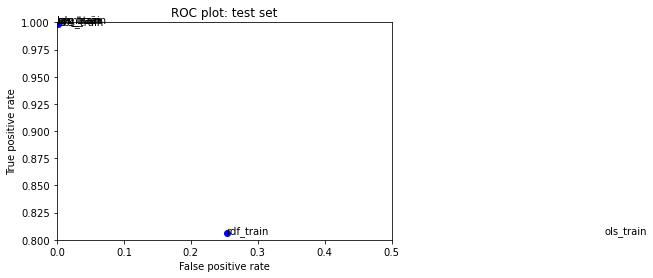

In [64]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.5, 0.8, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [65]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [66]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
26
There have been so many many films based on the same theme. single cute girl needs handsome boy to impress ex, pays him and then (guess what?) she falls in love with him, there's a bit of fumbling followed by a row before everyone makes up before the happy ending......this has been done many times.<br /><br />The thing is I knew this before starting to watch. But, despite this, I was still looking forward to it. In the right hands, with a good cast and a bright script it can still be a pleasant way to pass a couple of hours.<br /><br />this was none of these.<br /><br />this was dire.<br /><br />A female lead lacking in charm or wit who totally failed to light even the slightest spark in me. I truly did not care if she \got her man\" or remained single and unhappy.<br /><br />A male lead who, after a few of his endless words of wisdom, i wanted to kill. Just to remove that smug look. i had no idea that leading a life of a male whore was the path to all-s

2775
The only reason I don't give this movie fewer than 3 stars is because it isn't quite on par with a movie like Manos: The Hands of Fate. This movie's greatest crime is the fact that it is head-meltingly boring & terribly, unforgivably British. The premise of this movie sounds potentially promising, the whole teleporting concept, but the direction they went with it was completely uninteresting. It was more a movie about research funding and bowties than projecting lasers. The actors were wooden, unemotional, and aloof. As was the love affair between the two scientists-- which was anything but intriguing. I never was able to tell what the attraction was between them as the chemistry was non-existent. Nor did I really understand why the melty-faced main guy decided to slaughter everyone he met. At least now I know that I should always give someone a fair hearing before I cut off their research grants, else they go rampaging about, killing wantonly with goofy hand gestures.
* * * * * *

5621
I want to say the acting is bad, but I think it was the directing that made it so. I never thought much of Highlander (same director) but that one could be blamed on the 80s.<br /><br />This one however, has no excuses. People get shot while exiting trenches with a man in front of him!? Those kind of mistakes, along with an unclear time line, weird battle tactics, sub-par cutting and poor visual effects, makes this one a sub-par film over all.<br /><br />Then like so many other have commented, all this American bullshit. The German general being practically scared of his captured American private. Be prepared to swallow a lot of it, although in small doses.<br /><br />To sum it up, a not horrible but still definitely sub-par war movie in all aspects.
* * * * * * * * * 
5678
Comment this movie is impossible. Is terrible, very improbable, bad interpretation e direction. Not look!!!!!
* * * * * * * * * 
5750
This film may have been the biggest let-down I've experienced in renting mov

7854
Don't waste your time or money on this one. The half decent cast might fool you into thinking that this teen-thriller, whilst hardly about to break any records, might lightly entertain for 80 minutes.<br /><br />It won't.<br /><br />It won't make you scared, laugh, cry or even challenge your intellect. It will leave you wondering how on earth this movie ever finished production. Yes, it really is that poor.
* * * * * * * * * 
7974
I saw the 7.5 IMDb rating on this movie and on the basis of that decided to watch this movie which my roommate had rented. She said she had seen it before. \It's funny and sad! I cried the first time I saw it,\" she gushed. Maybe compared to other Bollywood movies this deserves a 7.5 out of 10, but in comparison to all the other movies I have seen in my lifetime, this deserves no more than a 3. Any movie where I can perpetually guess what is going to happen next is no good for me. The characters are unbelievable, how the act is not realistic at all and t

10257
Mimicking its long title the movie finds ways to come close to the 90' mark. The beautiful sets are here with all that made the Hamer production values a trademark, yet Paris drowned in the fog is a sign of indolent neglect. The story is obvious and can be summed up in a dozen words so there comes nothing unexpected and nothing worth more than 5% of your attention to be expected.<br /><br />The directing is heavy as a direct transfer from the stage play, actors are mostly stiff as wax figures (ok this is a Hamer feature, only it's sometimes better featured in the whole package). My conclusion: this movie is trash, not worth the time I spend that evening. Eternal life is a boring matter and I should have hoped the guys in charge of programming at the Cinemathèque would have known better.
* * * * * * * * * 
10260
In the third entry of the Phantasm series, Mike and Reggie continue chasing the Tall Man, assisted by a trigger-happy 9 year old, a black G.I. Jane and the spirit of Mike'

12327
Proof why Hollywood conventions are in place. Stale dialogue, underdeveloped and flat characters and a disjointed storyline are only part of the problems with this gangster classic wannabe. An attempt to be daring and different but this appears to be a slap-together attempt at recreating the magic of Arthur Penn 's Bonnie and Clyde (1967) and George Roy Hill 's Butch Cassidy and the Sundance Kid (1969)- truly innovative filmmakers and films - but falling well below the bar. Problems with storylines being self-explanatory result in the need for a voiceover to explain problem sections. The editing appears again to be an attempt to duplicate the previous classics but is occasionally disjointed and cause more problems for me technically. Unnecessary shots are thrown in to justify the filming of them but would have better served the viewer by sitting on the cutting room floor. Stills, black & white montages and period music are thrown in from time to time in attempts to either be diff

14340
Back (again) in Scotland, Lassie is (again) on trial for her life. Because the faithful dog sleeps on her master's grave, she must be put to death, according to law. Oddly, it is also explained that Lassie had no \legal\" owner, which is, apparently, also against an old Scottish law. If, after three days, no owner is located, dogs must be destroyed. Edmund Gwenn (as John Traill) pleads Lassie's case, which leads to an extended flashback, showing Lassie's adoption by Donald Crisp (as John \"Jock\" Gray).<br /><br />Although it's based on an interesting, original story (\"Greyfriars Bobby\"), \"Challenge to Lassie\" revisits several earlier Lassie situations; and, it does not improve upon them. Comparatively speaking, this one is sloppy and unexciting; and, it's a disappointing follow-up to \"The Sun Comes Up\" (1949) *******. Geraldine Brooks (as Susan Brown) and several of the other performers may be charming, but can't elevate this one. Little Jimmy Hawkins (from \"It's a Wonder

16320
This is very much a television version of the tale, the film starts out like an episode of 'Xena...', with little meaningful dialog or character description. It does get a bit more substantive after a while, but all characters are still cartoonish. <br /><br />Salma is the exotic beauty. Richard Harris is an evil and sexually repressed Frollo, fiending to bust a nut up in Salma. The other characters, including Quasimodo are quite forgettable. <br /><br />Its also a sorta liberal version of the story, Frollo is a suppressor of Enlightenment ideals, like the abbot in 'Name of the Rose', and Quasimodo is a champion of liberty. The shadowy side of the Quas character is ignored, though he does pour liquid led on people. He is really only an outsider in that he looks different and enjoys playing with bells more than the average person. <br /><br />Perhaps the film is intended for children, but I doubt it, considering Frollo flogs himself bloody to amend wanting to spank his monkey. A m

18725
\Loonatics Unleashed \" is the worst thing that could happen to the classic characters created by Chuck Jones . The \"Loony Tunes\" have many spin -offs and different versions , some were good ,others not very much .But \"Loonatics \" it's the worst .The concept is stupid and derivative of shows as \"The Power Rangers \" and \"Teen Titans \" . There wasn't any similarity with the original characters and the stories are boring and poorly made . The new designs are ugly and the animation is pathetic . This show just doesn't work .This horrible waste of animation is a complete failure and this shouldn't have be nothing more than a bad joke . Lame ! Zero stars"
* * * * * * * * * 
18747
I wanted to love this movie. How could I not love it? Cary Grant, Jayne Mansfield, Stanley Donen; all icons in their own way. However, the train wreck that was Suzy Parker ruined the entire experience for me. Her acting was so appalling that I sat there with my jaw hanging open, not believing my eyes o

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [67]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2198, 'TN': 228, 'FP': 2276, 'FN': 298, 'Accuracy': 0.4852, 'Precision': 0.49128296826106393, 'Recall': 0.8806089743589743, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [68]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2056, 'TN': 2034, 'FP': 470, 'FN': 440, 'Accuracy': 0.818, 'Precision': 0.8139350752177356, 'Recall': 0.8237179487179487, 'desc': 'svm_test'}


### MODEL: logistic regression

In [69]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2083, 'TN': 2051, 'FP': 453, 'FN': 413, 'Accuracy': 0.8268, 'Precision': 0.8213722397476341, 'Recall': 0.8345352564102564, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [70]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2109, 'TN': 2053, 'FP': 451, 'FN': 387, 'Accuracy': 0.8324, 'Precision': 0.823828125, 'Recall': 0.8449519230769231, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [71]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2024, 'TN': 2046, 'FP': 458, 'FN': 472, 'Accuracy': 0.814, 'Precision': 0.8154713940370669, 'Recall': 0.8108974358974359, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [72]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2208, 'TN': 2162, 'FP': 342, 'FN': 288, 'Accuracy': 0.874, 'Precision': 0.8658823529411764, 'Recall': 0.8846153846153846, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [73]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 1969, 'TN': 1790, 'FP': 714, 'FN': 527, 'Accuracy': 0.7518, 'Precision': 0.7338799850913157, 'Recall': 0.7888621794871795, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

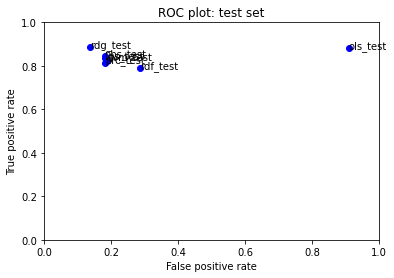

In [74]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [25]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='./moviereviews_test.tsv', my_random_seed=70, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [26]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.50088


In [27]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [28]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [29]:
my_submission.shape

(25000, 2)

In [30]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation